# Advanced Portfolio Optimisation

This notebook demonstrates a full portfolio-optimisation workflow using Python.  
We download historical market data, calculate risk–return metrics, run Monte Carlo simulations, optimise portfolios with SciPy, plot the Efficient Frontier and Capital Market Line, and backtest the results.  

It’s designed to showcase quantitative finance skills in data handling, risk modelling, optimisation, and visualisation.

## 1. Imports and Setup

Load the Python libraries we’ll use for data download, numerical analysis, optimisation, and plotting.  
We also set a random seed for reproducibility.


In [1]:
from scipy.optimize import minimize
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(5)


## 2. Download Market Data

Define a basket of 15 large-cap US stocks and fetch their monthly closing prices from Yahoo Finance using `yfinance`.  
This gives us a consistent time-series dataset to work with.


In [2]:
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA", "META",
           "NVDA", "NFLX", "JPM", "BAC", "V", "MA", "KO", "PEP", "DIS"]

data = yf.download(tickers, start="2000-01-01",
                   end="2024-01-01", interval="1mo")["Close"]

C:\Users\jackm\AppData\Local\Temp\ipykernel_29664\3829474800.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2000-01-01",
[*********************100%***********************]  15 of 15 completed


## Calculate Returns and Annualised Statistics

- Convert monthly prices into **monthly percentage returns** and remove missing values.  
- Resample the monthly returns to **annual returns** to estimate each asset’s yearly performance.  
- Compute the **mean annual returns** (μ) and **covariance matrix** (Σ) of the assets.  
- Store these in `mu` and `Sigma` for use in Monte Carlo simulation and portfolio optimisation.  
- Also define the number of assets, number of portfolios to simulate, and the assumed annual **risk-free rate**.


In [3]:
returns = data.pct_change().dropna()

annual_returns = (returns + 1).resample("YE").prod() - 1
mean_returns_s = annual_returns.mean()
cov_matrix_df = annual_returns.cov()

mu = mean_returns_s.values
Sigma = cov_matrix_df.values

num_assets = len(tickers)
num_portfolios = 100_000
risk_free_rate = 0.02  # 2% assumed annual risk-free rate

## Monte Carlo Simulation of Random Portfolios

- **Generate random portfolio weights** using a Dirichlet distribution so all weights are long-only and sum to 1.  
- For each random portfolio:
  - Calculate its **expected annual return** using the mean return vector (μ).  
  - Calculate its **annual volatility** (standard deviation) from the covariance matrix (Σ).  
  - Compute its **Sharpe ratio** relative to the risk-free rate.  
- Identify:
  - The **minimum-variance portfolio** (lowest volatility).  
  - The **maximum-Sharpe portfolio** (highest risk-adjusted return).  
- Print their weights and key performance metrics for inspection.


In [4]:
weights_mc = np.random.dirichlet(np.ones(num_assets), size=num_portfolios)

port_returns = weights_mc @ mu
port_std = np.array([np.sqrt(w @ Sigma @ w) for w in weights_mc])

eps = 1e-12
sharpe_ratio = (port_returns - risk_free_rate) / (port_std + eps)

max_sharpe_idx = np.argmax(sharpe_ratio)
min_var_idx = np.argmin(port_std)

print("Minimum Variance Portfolio (MC) weights:")
print(pd.Series(weights_mc[min_var_idx], index=tickers).round(4))
print("Return:", round(port_returns[min_var_idx], 4))
print("SD:", round(port_std[min_var_idx], 4))

print("\nMaximum Sharpe Portfolio (MC) weights:")
print(pd.Series(weights_mc[max_sharpe_idx], index=tickers).round(4))
print("Return:", round(port_returns[max_sharpe_idx], 4))
print("SD:", round(port_std[max_sharpe_idx], 4))
print("Sharpe Ratio:", round(sharpe_ratio[max_sharpe_idx], 4))


Minimum Variance Portfolio (MC) weights:
AAPL    0.0075
MSFT    0.0047
GOOG    0.0182
AMZN    0.0142
TSLA    0.0514
META    0.0662
NVDA    0.5721
NFLX    0.0305
JPM     0.0035
BAC     0.0319
V       0.0102
MA      0.0029
KO      0.0932
PEP     0.0152
DIS     0.0784
dtype: float64
Return: 0.1467
SD: 0.1068

Maximum Sharpe Portfolio (MC) weights:
AAPL    0.0035
MSFT    0.0086
GOOG    0.0104
AMZN    0.0136
TSLA    0.0216
META    0.0477
NVDA    0.2828
NFLX    0.0344
JPM     0.0006
BAC     0.0526
V       0.0136
MA      0.0809
KO      0.0699
PEP     0.0055
DIS     0.3543
dtype: float64
Return: 0.2286
SD: 0.1448
Sharpe Ratio: 1.4403


## Portfolio Optimisation with SciPy (Max Sharpe & Min Variance)

- **Define helper functions**:
  - `portfolio_perf`: calculates portfolio return, volatility, and Sharpe ratio given weights.
  - `neg_sharpe`: the negative Sharpe ratio (used because `minimize` only minimises).  
  - `portfolio_vol`: computes portfolio volatility (used for minimum-variance optimisation).

- **Set optimisation constraints**:
  - Long-only bounds (0 to 1 for each asset).
  - Full investment constraint (weights sum to 1).
  - Start from equal weights.

- **Run two optimisations**:
  - **Maximise Sharpe ratio** to find the tangency (optimal risk-adjusted) portfolio.
  - **Minimise variance** to find the lowest-risk portfolio.

- **Print out the resulting weights and performance metrics** for both optimised portfolios.

In [5]:
def portfolio_perf(w, mu_vec, cov_mat, rf):
    r = w @ mu_vec
    v = np.sqrt(w @ cov_mat @ w)
    s = (r - rf) / (v + eps)
    return r, v, s

def neg_sharpe(w, mu_vec, cov_mat, rf):
    return -portfolio_perf(w, mu_vec, cov_mat, rf)[2]

bounds = [(0.0, 1.0)] * num_assets
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
w0 = np.full(num_assets, 1.0 / num_assets)

res_ms = minimize(neg_sharpe, w0, args=(mu, Sigma, risk_free_rate),
                  method='SLSQP', bounds=bounds, constraints=cons)
w_opt = res_ms.x
ret_opt, vol_opt, sharpe_opt = portfolio_perf(w_opt, mu, Sigma, risk_free_rate)

print("\n===== Optimal Sharpe Portfolio (Optimiser) =====")
print(pd.Series(w_opt, index=tickers).round(4))
print(f"Expected Annual Return: {ret_opt:.4f}")
print(f"Annual Volatility: {vol_opt:.4f}")
print(f"Sharpe Ratio: {sharpe_opt:.4f}")

def portfolio_vol(w, mu_vec, cov_mat):
    return np.sqrt(w @ cov_mat @ w)

res_mv = minimize(portfolio_vol, w0, args=(mu, Sigma),
                  method='SLSQP', bounds=bounds, constraints=cons)
w_minvar = res_mv.x
ret_mv, vol_mv, sharpe_mv = portfolio_perf(w_minvar, mu, Sigma, risk_free_rate)

print("\n===== Minimum Variance Portfolio (Optimiser) =====")
print(pd.Series(w_minvar, index=tickers).round(4))
print(f"Expected Annual Return: {ret_mv:.4f}")
print(f"Annual Volatility: {vol_mv:.4f}")
print(f"Sharpe Ratio: {sharpe_mv:.4f}")



===== Optimal Sharpe Portfolio (Optimiser) =====
AAPL    0.0000
MSFT    0.0000
GOOG    0.0000
AMZN    0.0000
TSLA    0.0000
META    0.0000
NVDA    0.6344
NFLX    0.0000
JPM     0.0000
BAC     0.0000
V       0.0000
MA      0.0770
KO      0.0000
PEP     0.0039
DIS     0.2847
dtype: float64
Expected Annual Return: 0.1730
Annual Volatility: 0.0949
Sharpe Ratio: 1.6115

===== Minimum Variance Portfolio (Optimiser) =====
AAPL    0.0000
MSFT    0.0214
GOOG    0.0000
AMZN    0.0000
TSLA    0.0000
META    0.0000
NVDA    0.9456
NFLX    0.0000
JPM     0.0000
BAC     0.0000
V       0.0000
MA      0.0329
KO      0.0000
PEP     0.0000
DIS     0.0000
dtype: float64
Expected Annual Return: 0.1018
Annual Volatility: 0.0674
Sharpe Ratio: 1.2129


## Plot the Efficient Frontier with Optimised Portfolios and Capital Market Line

- **Plot all Monte Carlo portfolios** as a scatter cloud coloured by Sharpe ratio.  
- Highlight the **minimum-variance** and **maximum-Sharpe** portfolios from the Monte Carlo simulation.  
- Overlay the **optimised portfolios** (true max-Sharpe and min-variance) found with SciPy.  
- Draw the **Capital Market Line (CML)** from the risk-free rate through the tangency (max-Sharpe) portfolio to show the best achievable risk/return combinations.  
- Label axes, add a legend, and format the chart for a clear Efficient Frontier visualisation.

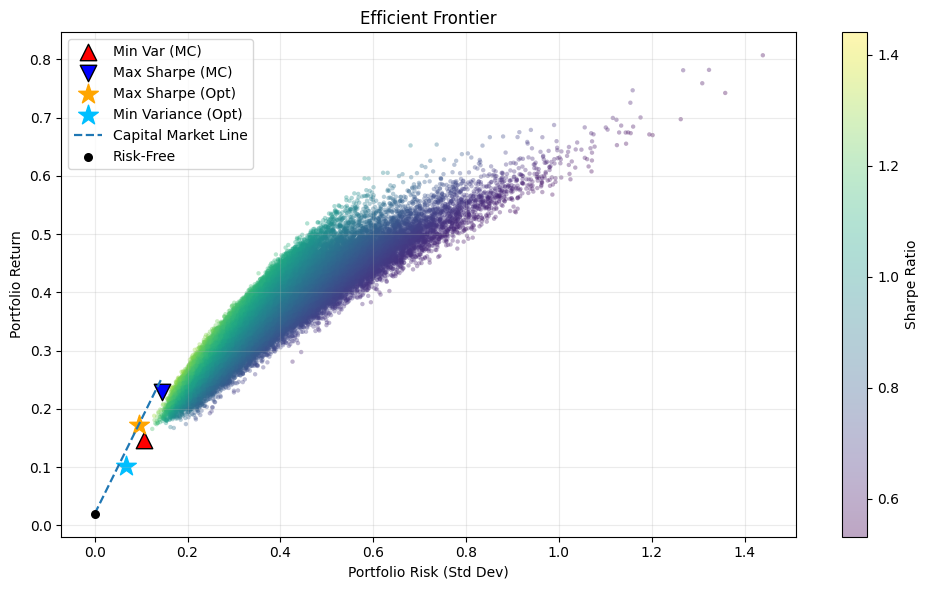

In [6]:
plt.figure(figsize=(10, 6))

sc = plt.scatter(port_std, port_returns, c=sharpe_ratio, cmap='viridis',
                 s=10, alpha=0.35, linewidths=0)
plt.colorbar(sc, label='Sharpe Ratio')
plt.scatter(port_std[min_var_idx], port_returns[min_var_idx],
            color='red', marker='^', s=140, edgecolors='black', label='Min Var (MC)')
plt.scatter(port_std[max_sharpe_idx], port_returns[max_sharpe_idx],
            color='blue', marker='v', s=140, edgecolors='black', label='Max Sharpe (MC)')

plt.scatter(vol_opt, ret_opt, marker='*', color='orange',
            s=220, label='Max Sharpe (Opt)')
plt.scatter(vol_mv, ret_mv, marker='*', color='deepskyblue',
            s=220, label='Min Variance (Opt)')

cml_slope = (ret_opt - risk_free_rate) / vol_opt
x = np.linspace(0, vol_opt*1.5, 80)
y = risk_free_rate + cml_slope * x
plt.plot(x, y, ls='--', lw=1.6, label='Capital Market Line')
plt.scatter(0, risk_free_rate, color='black', s=30, zorder=5, label='Risk-Free')

plt.xlabel('Portfolio Risk (Std Dev)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

## Backtest Portfolios over the Last 36 Months

- Select the most recent **36 months** of monthly returns for backtesting.  
- Define a `backtest` function to:
  - Apply a set of portfolio weights to the returns,
  - Compute cumulative performance over time.  
- Backtest:
  - **Monte Carlo max-Sharpe portfolio**,
  - **Monte Carlo min-variance portfolio**,
  - **Optimiser max-Sharpe portfolio**.  
- Print their **cumulative returns** at the end of the backtest window to compare recent performance.

In [7]:
Months = 36
short_r = returns.iloc[-Months:]

def backtest(weights, r):
    series = pd.Series(r.values @ weights, index=r.index)
    return (1 + series).cumprod() - 1

bt_mc_ms = backtest(weights_mc[max_sharpe_idx], short_r)
bt_mc_mv = backtest(weights_mc[min_var_idx], short_r)
bt_opt_ms = backtest(w_opt, short_r)

print(f"\nCumulative Return (last {Months} months):")
print(f"  Max Sharpe (MC) : {(bt_mc_ms.iloc[-1]*100):.2f}%")
print(f"  Min Var (MC)    : {(bt_mc_mv.iloc[-1]*100):.2f}%")
print(f"  Max Sharpe (Opt): {(bt_opt_ms.iloc[-1]*100):.2f}%")



Cumulative Return (last 36 months):
  Max Sharpe (MC) : 43.52%
  Min Var (MC)    : 27.82%
  Max Sharpe (Opt): 36.40%


## Plot Backtest Cumulative Returns

- Plot the **cumulative returns** of all three portfolios over the last 36 months:
  - Max Sharpe (Monte Carlo),
  - Min Variance (Monte Carlo),
  - Max Sharpe (Optimiser).  
- This visualises how each portfolio would have performed recently and makes it easy to compare risk-adjusted strategies over time.  
- Label the axes, add a title and legend for clarity.

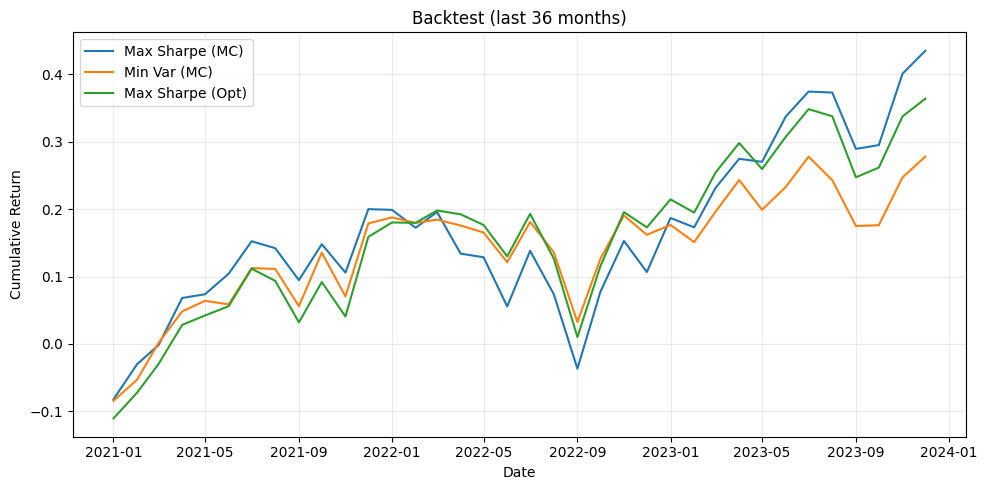

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(bt_mc_ms, label="Max Sharpe (MC)")
plt.plot(bt_mc_mv, label="Min Var (MC)")
plt.plot(bt_opt_ms, label="Max Sharpe (Opt)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Backtest (last 36 months)")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()